<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe67701-uncertainty-quantification](https://ndcbe.github.io/cbe67701-uncertainty-quantification);
content is available [on Github](git@github.com:ndcbe/cbe67701-uncertainty-quantification.git).*

<!--NAVIGATION-->
< [4.1 Local sensitivity analysis and difference approximation](https://ndcbe.github.io/cbe67701-uncertainty-quantification/04.01-Local-sensitivity-analysis.html) | [Contents](toc.html) | [5.0 Regression Approximations to Estimate Sensitivities](https://ndcbe.github.io/cbe67701-uncertainty-quantification/05.00-Regression-Approximations-to-Estimate-Sensitivities.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/04.02-Simple-ADR-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/04.02-Simple-ADR-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 4.2 Advection-Diffusion-Reaction (ADR) Example
Noah Wamble (nwamble@nd.edu) 
June 22nd, 2020

This example was adapted from code from:

McClarren, Ryan G (2018). *Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers*, *Chapter 4: Local Sensitivity Analysis Based on Derivative Approximations*, Springer, https://doi.org/10.1007/978-3-319-99525-0_4

### 4.2.1 **What do we want to know?** 

* How would the QoIs vary for small, expected perturbations in the inputs if given knowledge of the QoI at a particular value? To accomplish this, we are interested in the derivative of the QoI at a nominal input value (95).

### 4.2.2 **Why do we want to know that?**


* This information will allow us **to see which parameters have a larger effect** on the QoI. 

* Knowing the sensitivities allows the researcher **to narrow the focus** to a smaller number of parameters and then apply more rigorous techniques to only these parameters. 

* If the variabilities in these distributions are small, it may be possible to **quantify the uncertainty** in the QoI to these parameters using only local information (95).


### 4.2.3 **4.3.1 Simple ADR Example** 
We will study the steady advection-diffusion-reaction equation  in one-spatial dimension with a spatially constant, but uncertain, diffusion coefficient, a linear reaction term, and a prescribed uncertain source.

$$
\nu \frac{du}{dx} - \omega \frac{d^2u}{dx^2} + \kappa(x)u = S(x)
$$
With initial condition: 
$$
 u(0)=u(10)=0
$$
Where:
$$
\kappa(x) =     \begin{cases}
      \kappa_l & x \: \epsilon \: (5,7.5)\\
      \kappa_h & \text{otherwise}\\
    \end{cases} 
$$
$$
$$
$$ 
S(x)= qx(10-x)
$$

With $\mu_v =10$, $\mu_\omega= 20$, Var$(\mu_v)=0.0723493$, Var$(\omega)= 0.3195214$



 $\mu_{\kappa_h} = 2$, Var$( \kappa_h ) = 0.002778142$ , and $\mu_{k_l} = 0.1$, Var$( \kappa_l )= 8.511570 \times 10^{-6}$, $\mu_q = 1,$ Var$(q)= 7.062353 \times 10^{-4}$ 

We also prescribe that the parameters ordered as $(\nu,\omega,\kappa_l,\kappa_u,q)$ have the following correlation matrix: 

$$
R= 
\begin{pmatrix}
1.00 & 0.10 & -0.05 & 0.00 & 0.00\\
0.10 & 1.00 & -0.40 & 0.30 & 0.50 \\
0.00 & 0.30 & 0.20 & 1.00 & -0.10 \\
0.00 & 0.50 & 0.00 & -0.10 & 1.00 \\
\end{pmatrix}
$$
The QoI is total reaction rate: 
$$
Q= \int^{10}_{0} \kappa(x_ u)(x)dx
$$


**Import Libraries**



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate
import math

**Numerical Method to Solve ADR Equation** 

In [2]:
def ADRSource(Lx, Nx, Source, omega, v, kappa):
    """
    This function solves the diffusion equation with a generalized source. 
    
    Inputs 
    Lx, Nx: Used to make the size of the dx term 
    Source: Source function
    omega: diffusion coefficient 
    v: velocity field  
    kappa: reaction coefficient equation 


    Outputs:
    Solution: u(x) values 
    Q: Total reaction rate 
    
    """
    
    #Initialize A matrix that will be solved 
    A = sparse.dia_matrix((Nx,Nx),dtype="complex")
    #Initialize size of dx step 
    dx = Lx/Nx
    i2dx2 = 1.0/(dx*dx)
    #fill diagonal of A
    A.setdiag(2*i2dx2*omega + np.sign(v)*v/dx + kappa)
    #fill off diagonals of A
    A.setdiag(-i2dx2*omega[1:Nx] +
              0.5*(1-np.sign(v[1:Nx]))*v[1:Nx]/dx,1)
    A.setdiag(-i2dx2*omega[0:(Nx-1)] -
              0.5*(np.sign(v[0:(Nx-1)])+1)*v[0:(Nx-1)]/dx,-1)
    
    #solving equation A x = Source
    Solution = linalg.spsolve(A,Source)
    #Use trapezoidal integrater to find integral
    Q = integrate.trapz(Solution*kappa,dx=dx)

    return Solution, Q

**Define Parameters**

/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


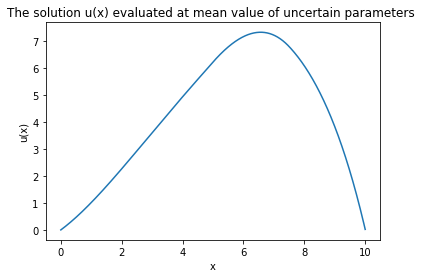

In [3]:
#Define desired spatial map and step
Lx = 10
Nx = 2000
dx = Lx/Nx

#Define functions that will be used by numerical solver 
#source function 
Source_func = lambda x, q:  q*x*(10-x)
#reaction constants 
kappa_func = lambda x, kappal, kappah: kappah + (kappal-kappah)*(x>5)*(x<7.5)
#Initialize these to the correct size 
v_func = lambda x,v: v*np.ones(x.size)
omega_func = lambda x,omega: omega*np.ones(x.size)

#Define array for plotting purposes 
xs = np.linspace(dx/2,Lx-dx/2,Nx)

# evaluate source and kappa
source = Source_func(xs, 1)
kappa = kappa_func(xs, 0.1, 2)

#nominal values and given variances 
omega_nom = 20
omega_var = 0.3195214
v_nom = 10
v_var = 0.0723493
kappal_nom = 0.1
kappal_var = 8.511570e-6
kappah_nom = 2
kappah_var = 0.002778142
q_nom = 1
q_var = 7.062353e-4
vs = v_func(xs, v_nom)
# print(vs)

#Call Numerical Function above to solve equation 
sol,Q = ADRSource(Lx, Nx, source, omega_func(xs, omega_nom), vs, kappa)
# print(Q)

#Plot solution 
plt.plot(xs,sol)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('The solution u(x) evaluated at mean value of uncertain parameters ')
plt.show()


**Sensitivity Analysis** 

Sensitivity using Forward Difference Derivative Approximation: 

$$
\frac{\partial Q}{\partial x_i} \bigg|_{\overline{x}} \approx \frac{Q(\overline{x} + \delta_i\hat{e_i}) - Q(\overline{x})}{\delta_i}
$$
Scaled Sensitivity Coefficient: 

$$
\overline{x_i}\frac{\delta Q}{\delta x_i}\bigg|_\overline{x}
$$

Sensitivity Index:
$$
\sigma_i\frac{\delta Q}{\delta x_i}\bigg|_\overline{x}
$$

In [4]:

#v sensitivity
#finite difference step amount 
delta = 1e-6
vs_pert = v_func(xs, v_nom*(1+delta))
#Calculate second point for finite difference
sol,Q_new = ADRSource(Lx, Nx, source, omega_func(xs, omega_nom), vs_pert, kappa)
#finite difference Sensitivity Calculation 
sens_v = (Q_new - Q)/(v_nom*delta)
#Scaled Sensitivity 
scaled_v = sens_v*v_nom
#Sensitivity Index 
index_v = math.sqrt(v_var)*sens_v
#Print Commands 
print('######################### Sensitivity Analysis #################')
print("v sensitivity: ", sens_v)
print("v scaled sensitivity: ", scaled_v)
print("v Sensitivity index: ", index_v)
print('\n')

#omega sensitivity
#Calculate second point for finite difference 
sol,Q_new = ADRSource(Lx, Nx, source, omega_func(xs, omega_nom*(1+delta)), vs, kappa)
#Sensitivity calculation using finite difference 
sens_omega = (Q_new - Q)/(omega_nom*delta)
#Scaled sensitivity Calc
scaled_v = sens_omega*omega_nom
#Sensitivity Index Calc
index_v = math.sqrt(omega_var)*sens_omega
#Print Commands 
print("omega sensitivity: ", sens_omega)
print("omega scaled sensitivity: ", scaled_v)
print("omega sensitivity index: ", index_v)
print('\n')

#kappal sensitivity
#Calculate second point value for finite difference 
sol,Q_new = ADRSource(Lx, Nx, source, omega_func(xs, omega_nom), vs, kappa_func(xs, kappal_nom*(1+delta), 2))
#Sensitivity Calculation using finite difference 
sens_kappal = (Q_new - Q)/(kappal_nom*delta)
#Scaled Sensitivity Calc 
scaled_v = sens_kappal*kappal_nom
#Sensitivity Index Calc
index_v = math.sqrt(kappal_var)*sens_kappal
#Print Commands 
print("Kappa_l sensitivity: ", sens_kappal)
print("Kappa_l scaled sensitivity: ", scaled_v)
print("Kappa_l sensitivity index: ", index_v)
print('\n')

#kappah sensitivity
#Calculate second point value for finite difference 
sol,Q_new = ADRSource(Lx, Nx, source, omega_func(xs, omega_nom), vs, kappa_func(xs, kappal_nom, kappah_nom*(1+delta)))
#Sensitivity Calculation using finite difference 
sens_kappah = (Q_new - Q)/(kappah_nom*delta)
#Scaled Sensitivity Calc
scaled_v = sens_kappah*kappah_nom
#Sensitivity Index Calc
index_v = math.sqrt(kappah_var)*sens_kappah
#Print Commands 
print("Kappa_h sensitivity: ", sens_kappah)
print("Kappa_h scaled sensitivity: ", scaled_v)
print("Kappa_h sensitivity index: ", index_v)
print('\n')

#q sensitivity
#Calculate second point value for finite difference 
sol,Q_new = ADRSource(Lx, Nx, Source_func(xs, q_nom*(1+delta)), omega_func(xs, omega_nom), vs,kappa_func(xs, kappal_nom, kappah_nom))
sens_q = (Q_new - Q)/(q_nom*delta)
#Scaled Sensitivity Calc
scaled_v = sens_q*q_nom
#Sensitivity Index Calc
index_v = math.sqrt(q_var)*sens_q
#print commands
print("q sensitivity: ", sens_q)
print("q scaled sensitivity: ", scaled_v)
print("q sensitivity index: ", index_v)
print('\n')

######################### Sensitivity Analysis #################
v sensitivity:  (-1.7406387549101512+0j)
v scaled sensitivity:  (-17.406387549101513+0j)
v Sensitivity index:  (-0.46819396950072134+0j)


omega sensitivity:  (-0.970203846506479+0j)
omega scaled sensitivity:  (-19.40407693012958+0j)
omega sensitivity index:  (-0.5484195995587706+0j)


Kappa_l sensitivity:  (12.867971008745371+0j)
Kappa_l scaled sensitivity:  (1.2867971008745371+0j)
Kappa_l sensitivity index:  (0.0375417844104318+0j)


Kappa_h sensitivity:  (17.761271102756382+0j)
Kappa_h scaled sensitivity:  (35.522542205512764+0j)
Kappa_h sensitivity index:  (0.9361625491891298+0j)


q sensitivity:  (52.39025306025269+0j)
q scaled sensitivity:  (52.39025306025269+0j)
q sensitivity index:  (1.3922755832423062+0j)




<!--NAVIGATION-->
< [4.1 Local sensitivity analysis and difference approximation](https://ndcbe.github.io/cbe67701-uncertainty-quantification/04.01-Local-sensitivity-analysis.html) | [Contents](toc.html) | [5.0 Regression Approximations to Estimate Sensitivities](https://ndcbe.github.io/cbe67701-uncertainty-quantification/05.00-Regression-Approximations-to-Estimate-Sensitivities.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/04.02-Simple-ADR-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/04.02-Simple-ADR-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>